# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

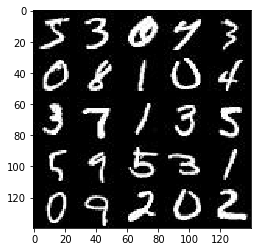

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

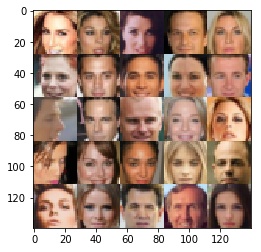

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_inputs = tf.placeholder(tf.float32, 
                                 (None, image_width, image_height, image_channels), 
                                  name='real_input')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_inputs, z_inputs, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.1
        
        #Layer 1
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        relu1 = tf.maximum(alpha * conv1, conv1)
        dropout1 = tf.layers.dropout(relu1, rate=0.5)
        
        #Layer 2
        conv2 = tf.layers.conv2d(dropout1, 128, 5, strides=2, padding='SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(0.01 * batch_norm2, batch_norm2)
        dropout2 = tf.layers.dropout(relu2, rate=0.5)
        
        #Layer 3
        conv3 = tf.layers.conv2d(dropout2, 256, 5, strides=2, padding='SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(0.01 * batch_norm3, batch_norm3)
        dropout3 = tf.layers.dropout(relu3, rate=0.5)
        
        #Layer 4
        flat = tf.reshape(dropout3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """      
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        alpha = 0.1
        if is_train is True:
            drop = 0.5
        else:
            drop = 1.0
            
        g1 = tf.layers.dense(z, 7*7*512)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        batch_norm1 = tf.layers.batch_normalization(g1, training=is_train)
        relu1 = tf.maximum(alpha * batch_norm1, batch_norm1)
        dropout1 = tf.layers.dropout(relu1, rate=0.5)
        
        g2 = tf.layers.conv2d_transpose(dropout1, 256, 5, strides=2, padding='SAME')
        batch_norm2 = tf.layers.batch_normalization(g2, training=is_train)
        relu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        dropout2 = tf.layers.dropout(relu2, rate=0.5)
        
        logits = tf.layers.conv2d_transpose(dropout2, out_channel_dim, 5, strides=2, padding='SAME')

        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*0.9))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*0.9))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1=0.5):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies(update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, 
          get_batches, data_shape, data_image_mode,print_every=10, 
          show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #build network
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2],
                                           data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for x in get_batches(batch_size):
                steps += 1
                x = x*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: x, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate, input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: x})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)

    return losses, samples     

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5002... Generator Loss: 2.1230
Epoch 1/2... Discriminator Loss: 0.4494... Generator Loss: 2.5265
Epoch 1/2... Discriminator Loss: 0.6503... Generator Loss: 1.6741
Epoch 1/2... Discriminator Loss: 0.6127... Generator Loss: 2.0905
Epoch 1/2... Discriminator Loss: 0.9958... Generator Loss: 2.7085
Epoch 1/2... Discriminator Loss: 0.8290... Generator Loss: 1.2807
Epoch 1/2... Discriminator Loss: 1.1574... Generator Loss: 0.7431
Epoch 1/2... Discriminator Loss: 1.6270... Generator Loss: 0.4946
Epoch 1/2... Discriminator Loss: 1.0351... Generator Loss: 1.1597
Epoch 1/2... Discriminator Loss: 1.2808... Generator Loss: 0.6556


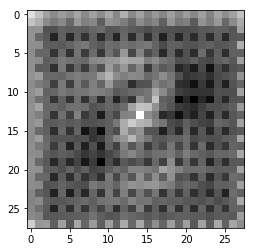

Epoch 1/2... Discriminator Loss: 1.0870... Generator Loss: 0.8793
Epoch 1/2... Discriminator Loss: 1.1371... Generator Loss: 0.8089
Epoch 1/2... Discriminator Loss: 1.0993... Generator Loss: 1.0107
Epoch 1/2... Discriminator Loss: 0.9932... Generator Loss: 1.0017
Epoch 1/2... Discriminator Loss: 0.8728... Generator Loss: 1.0995
Epoch 1/2... Discriminator Loss: 0.9700... Generator Loss: 0.9350
Epoch 1/2... Discriminator Loss: 1.2048... Generator Loss: 0.6676
Epoch 1/2... Discriminator Loss: 0.9186... Generator Loss: 1.3277
Epoch 1/2... Discriminator Loss: 1.0972... Generator Loss: 0.7876
Epoch 1/2... Discriminator Loss: 1.0113... Generator Loss: 0.8669


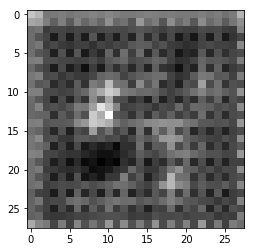

Epoch 1/2... Discriminator Loss: 0.9459... Generator Loss: 1.5984
Epoch 1/2... Discriminator Loss: 0.8220... Generator Loss: 1.3477
Epoch 1/2... Discriminator Loss: 0.9770... Generator Loss: 0.8174
Epoch 1/2... Discriminator Loss: 0.8204... Generator Loss: 1.1475
Epoch 1/2... Discriminator Loss: 0.7673... Generator Loss: 1.2085
Epoch 1/2... Discriminator Loss: 0.7422... Generator Loss: 1.8799
Epoch 1/2... Discriminator Loss: 0.8439... Generator Loss: 1.5222
Epoch 1/2... Discriminator Loss: 0.8425... Generator Loss: 1.8609
Epoch 1/2... Discriminator Loss: 0.6944... Generator Loss: 1.6868
Epoch 1/2... Discriminator Loss: 0.8117... Generator Loss: 1.1457


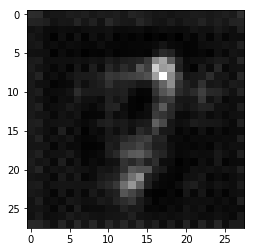

Epoch 1/2... Discriminator Loss: 0.6048... Generator Loss: 1.7954
Epoch 1/2... Discriminator Loss: 0.7369... Generator Loss: 1.3090
Epoch 1/2... Discriminator Loss: 0.6441... Generator Loss: 2.0823
Epoch 1/2... Discriminator Loss: 0.6902... Generator Loss: 1.9644
Epoch 1/2... Discriminator Loss: 0.9168... Generator Loss: 1.0888
Epoch 1/2... Discriminator Loss: 0.7916... Generator Loss: 1.1877
Epoch 1/2... Discriminator Loss: 0.9379... Generator Loss: 0.9528
Epoch 1/2... Discriminator Loss: 0.7651... Generator Loss: 1.2075
Epoch 1/2... Discriminator Loss: 0.7626... Generator Loss: 1.5240
Epoch 1/2... Discriminator Loss: 0.7785... Generator Loss: 1.4701


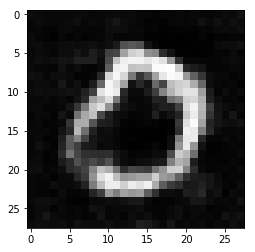

Epoch 1/2... Discriminator Loss: 0.7786... Generator Loss: 1.6745
Epoch 1/2... Discriminator Loss: 0.8980... Generator Loss: 1.1085
Epoch 1/2... Discriminator Loss: 0.9654... Generator Loss: 0.9217
Epoch 1/2... Discriminator Loss: 0.9818... Generator Loss: 1.7612
Epoch 1/2... Discriminator Loss: 0.9602... Generator Loss: 0.9166
Epoch 1/2... Discriminator Loss: 0.7313... Generator Loss: 1.7898
Epoch 1/2... Discriminator Loss: 1.3003... Generator Loss: 3.1550
Epoch 1/2... Discriminator Loss: 0.7852... Generator Loss: 1.2134
Epoch 1/2... Discriminator Loss: 0.7937... Generator Loss: 1.2637
Epoch 1/2... Discriminator Loss: 1.0417... Generator Loss: 0.8687


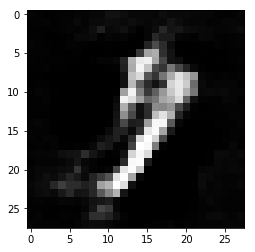

Epoch 1/2... Discriminator Loss: 0.8568... Generator Loss: 1.1509
Epoch 1/2... Discriminator Loss: 0.7579... Generator Loss: 1.6694
Epoch 1/2... Discriminator Loss: 0.8015... Generator Loss: 1.1959
Epoch 1/2... Discriminator Loss: 0.9073... Generator Loss: 1.8110
Epoch 1/2... Discriminator Loss: 0.8507... Generator Loss: 1.0310
Epoch 1/2... Discriminator Loss: 0.8642... Generator Loss: 1.6728
Epoch 1/2... Discriminator Loss: 1.0045... Generator Loss: 0.9623
Epoch 1/2... Discriminator Loss: 1.5186... Generator Loss: 0.5472
Epoch 1/2... Discriminator Loss: 1.0757... Generator Loss: 0.7558
Epoch 1/2... Discriminator Loss: 0.8622... Generator Loss: 0.9884


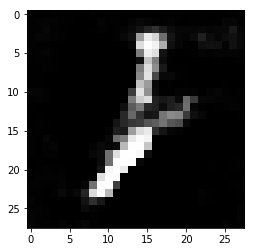

Epoch 1/2... Discriminator Loss: 0.7832... Generator Loss: 2.1639
Epoch 1/2... Discriminator Loss: 0.9088... Generator Loss: 1.6726
Epoch 1/2... Discriminator Loss: 0.9698... Generator Loss: 0.8841
Epoch 1/2... Discriminator Loss: 0.9375... Generator Loss: 0.9273
Epoch 1/2... Discriminator Loss: 0.9165... Generator Loss: 1.1149
Epoch 1/2... Discriminator Loss: 1.2149... Generator Loss: 0.7323
Epoch 1/2... Discriminator Loss: 0.9484... Generator Loss: 1.0116
Epoch 1/2... Discriminator Loss: 0.8937... Generator Loss: 1.1082
Epoch 1/2... Discriminator Loss: 1.0679... Generator Loss: 0.7936
Epoch 1/2... Discriminator Loss: 0.8713... Generator Loss: 1.1943


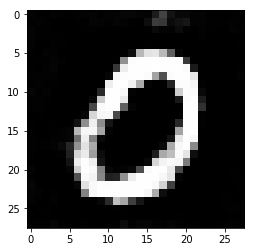

Epoch 1/2... Discriminator Loss: 0.7218... Generator Loss: 1.3630
Epoch 1/2... Discriminator Loss: 0.9458... Generator Loss: 1.5120
Epoch 1/2... Discriminator Loss: 0.8075... Generator Loss: 1.2515
Epoch 1/2... Discriminator Loss: 1.2166... Generator Loss: 0.6836
Epoch 1/2... Discriminator Loss: 1.1958... Generator Loss: 0.7619
Epoch 1/2... Discriminator Loss: 1.1237... Generator Loss: 0.7514
Epoch 1/2... Discriminator Loss: 0.8267... Generator Loss: 1.2261
Epoch 1/2... Discriminator Loss: 0.7453... Generator Loss: 1.6683
Epoch 1/2... Discriminator Loss: 0.7993... Generator Loss: 1.3437
Epoch 1/2... Discriminator Loss: 0.8401... Generator Loss: 1.3026


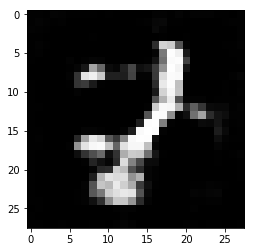

Epoch 1/2... Discriminator Loss: 0.9374... Generator Loss: 0.9983
Epoch 1/2... Discriminator Loss: 0.7989... Generator Loss: 2.1324
Epoch 1/2... Discriminator Loss: 0.7362... Generator Loss: 1.3211
Epoch 1/2... Discriminator Loss: 0.7544... Generator Loss: 1.3326
Epoch 1/2... Discriminator Loss: 0.8765... Generator Loss: 1.1143
Epoch 1/2... Discriminator Loss: 0.8437... Generator Loss: 1.0997
Epoch 1/2... Discriminator Loss: 0.8050... Generator Loss: 1.1807
Epoch 1/2... Discriminator Loss: 1.1024... Generator Loss: 0.7258
Epoch 1/2... Discriminator Loss: 0.7894... Generator Loss: 1.1276
Epoch 1/2... Discriminator Loss: 0.8202... Generator Loss: 1.1397


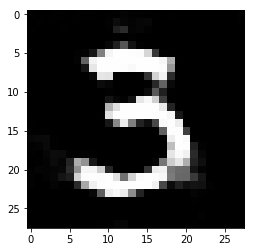

Epoch 1/2... Discriminator Loss: 0.8123... Generator Loss: 1.1234
Epoch 1/2... Discriminator Loss: 1.5827... Generator Loss: 0.5663
Epoch 1/2... Discriminator Loss: 1.6725... Generator Loss: 0.5294
Epoch 2/2... Discriminator Loss: 1.0465... Generator Loss: 1.0249
Epoch 2/2... Discriminator Loss: 0.9802... Generator Loss: 0.9070
Epoch 2/2... Discriminator Loss: 0.7730... Generator Loss: 1.3991
Epoch 2/2... Discriminator Loss: 0.9623... Generator Loss: 0.8813
Epoch 2/2... Discriminator Loss: 0.7488... Generator Loss: 1.5455
Epoch 2/2... Discriminator Loss: 0.8130... Generator Loss: 1.3609
Epoch 2/2... Discriminator Loss: 0.7132... Generator Loss: 1.5242


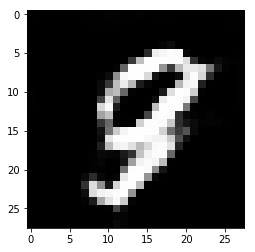

Epoch 2/2... Discriminator Loss: 1.0025... Generator Loss: 0.9080
Epoch 2/2... Discriminator Loss: 1.3736... Generator Loss: 0.6236
Epoch 2/2... Discriminator Loss: 0.7761... Generator Loss: 1.8078
Epoch 2/2... Discriminator Loss: 0.8895... Generator Loss: 1.2868
Epoch 2/2... Discriminator Loss: 0.7943... Generator Loss: 1.2718
Epoch 2/2... Discriminator Loss: 0.7659... Generator Loss: 1.3872
Epoch 2/2... Discriminator Loss: 1.0173... Generator Loss: 0.8797
Epoch 2/2... Discriminator Loss: 0.8195... Generator Loss: 1.0954
Epoch 2/2... Discriminator Loss: 0.7138... Generator Loss: 1.5661
Epoch 2/2... Discriminator Loss: 0.9363... Generator Loss: 1.0062


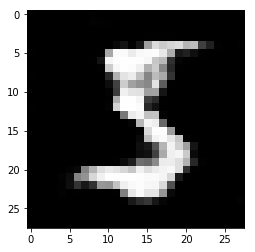

Epoch 2/2... Discriminator Loss: 0.8949... Generator Loss: 0.9888
Epoch 2/2... Discriminator Loss: 0.7816... Generator Loss: 1.5725
Epoch 2/2... Discriminator Loss: 0.8289... Generator Loss: 1.0935
Epoch 2/2... Discriminator Loss: 0.8391... Generator Loss: 1.0472
Epoch 2/2... Discriminator Loss: 0.7296... Generator Loss: 1.2832
Epoch 2/2... Discriminator Loss: 0.6802... Generator Loss: 1.3609
Epoch 2/2... Discriminator Loss: 0.7743... Generator Loss: 1.2269
Epoch 2/2... Discriminator Loss: 1.1493... Generator Loss: 0.7765
Epoch 2/2... Discriminator Loss: 0.6092... Generator Loss: 1.7093
Epoch 2/2... Discriminator Loss: 0.7815... Generator Loss: 1.2337


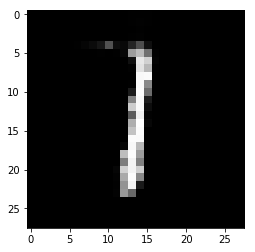

Epoch 2/2... Discriminator Loss: 0.6508... Generator Loss: 1.5489
Epoch 2/2... Discriminator Loss: 0.9034... Generator Loss: 1.0544
Epoch 2/2... Discriminator Loss: 0.6995... Generator Loss: 1.3129
Epoch 2/2... Discriminator Loss: 0.7086... Generator Loss: 2.0520
Epoch 2/2... Discriminator Loss: 0.7864... Generator Loss: 1.3994
Epoch 2/2... Discriminator Loss: 0.7058... Generator Loss: 1.6019
Epoch 2/2... Discriminator Loss: 0.6041... Generator Loss: 1.6820
Epoch 2/2... Discriminator Loss: 1.0158... Generator Loss: 1.4844
Epoch 2/2... Discriminator Loss: 0.7582... Generator Loss: 1.3121
Epoch 2/2... Discriminator Loss: 0.6293... Generator Loss: 1.6330


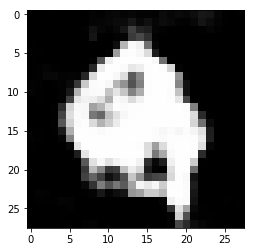

Epoch 2/2... Discriminator Loss: 0.7982... Generator Loss: 1.6623
Epoch 2/2... Discriminator Loss: 0.7632... Generator Loss: 1.2283
Epoch 2/2... Discriminator Loss: 0.8046... Generator Loss: 1.6863
Epoch 2/2... Discriminator Loss: 0.6816... Generator Loss: 1.3777
Epoch 2/2... Discriminator Loss: 0.9116... Generator Loss: 0.9784
Epoch 2/2... Discriminator Loss: 0.8300... Generator Loss: 1.1268
Epoch 2/2... Discriminator Loss: 1.2245... Generator Loss: 0.6527
Epoch 2/2... Discriminator Loss: 0.6808... Generator Loss: 1.5792
Epoch 2/2... Discriminator Loss: 0.7572... Generator Loss: 1.2231
Epoch 2/2... Discriminator Loss: 0.6954... Generator Loss: 1.4343


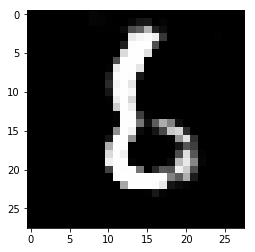

Epoch 2/2... Discriminator Loss: 0.7289... Generator Loss: 1.4575
Epoch 2/2... Discriminator Loss: 0.5769... Generator Loss: 1.9188
Epoch 2/2... Discriminator Loss: 0.7845... Generator Loss: 1.2621
Epoch 2/2... Discriminator Loss: 0.9566... Generator Loss: 0.9142
Epoch 2/2... Discriminator Loss: 1.5425... Generator Loss: 0.5489
Epoch 2/2... Discriminator Loss: 1.0304... Generator Loss: 0.9497
Epoch 2/2... Discriminator Loss: 0.7714... Generator Loss: 1.2270
Epoch 2/2... Discriminator Loss: 0.6593... Generator Loss: 1.7260
Epoch 2/2... Discriminator Loss: 0.7974... Generator Loss: 1.0926
Epoch 2/2... Discriminator Loss: 0.7698... Generator Loss: 1.6312


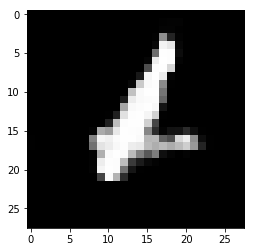

Epoch 2/2... Discriminator Loss: 0.6861... Generator Loss: 1.4767
Epoch 2/2... Discriminator Loss: 0.6672... Generator Loss: 1.5790
Epoch 2/2... Discriminator Loss: 0.6572... Generator Loss: 1.4146
Epoch 2/2... Discriminator Loss: 0.7026... Generator Loss: 1.4041
Epoch 2/2... Discriminator Loss: 0.6975... Generator Loss: 1.9504
Epoch 2/2... Discriminator Loss: 0.7347... Generator Loss: 1.4506
Epoch 2/2... Discriminator Loss: 0.7134... Generator Loss: 1.4090
Epoch 2/2... Discriminator Loss: 0.6729... Generator Loss: 1.4106
Epoch 2/2... Discriminator Loss: 1.5977... Generator Loss: 0.5343
Epoch 2/2... Discriminator Loss: 0.7530... Generator Loss: 1.2597


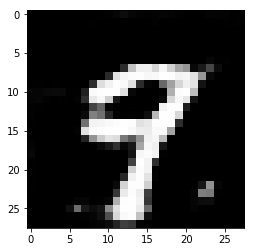

Epoch 2/2... Discriminator Loss: 0.7843... Generator Loss: 1.1886
Epoch 2/2... Discriminator Loss: 0.6845... Generator Loss: 1.4517
Epoch 2/2... Discriminator Loss: 1.0421... Generator Loss: 0.7850
Epoch 2/2... Discriminator Loss: 0.6459... Generator Loss: 1.6155
Epoch 2/2... Discriminator Loss: 0.7391... Generator Loss: 1.5026
Epoch 2/2... Discriminator Loss: 0.7274... Generator Loss: 1.4246
Epoch 2/2... Discriminator Loss: 0.7155... Generator Loss: 1.2163
Epoch 2/2... Discriminator Loss: 0.7880... Generator Loss: 1.2050
Epoch 2/2... Discriminator Loss: 0.8157... Generator Loss: 1.1663
Epoch 2/2... Discriminator Loss: 0.7475... Generator Loss: 1.8378


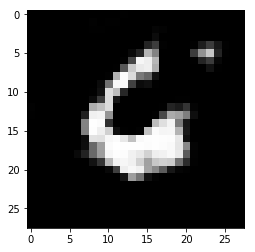

Epoch 2/2... Discriminator Loss: 0.7667... Generator Loss: 1.1340
Epoch 2/2... Discriminator Loss: 0.7128... Generator Loss: 1.3168
Epoch 2/2... Discriminator Loss: 0.8954... Generator Loss: 0.9313
Epoch 2/2... Discriminator Loss: 0.9045... Generator Loss: 1.0002
Epoch 2/2... Discriminator Loss: 0.7585... Generator Loss: 1.2370
Epoch 2/2... Discriminator Loss: 0.6946... Generator Loss: 1.4563
Epoch 2/2... Discriminator Loss: 0.8532... Generator Loss: 1.0698
Epoch 2/2... Discriminator Loss: 0.8710... Generator Loss: 1.0429
Epoch 2/2... Discriminator Loss: 1.1051... Generator Loss: 0.7858
Epoch 2/2... Discriminator Loss: 1.1329... Generator Loss: 0.7516


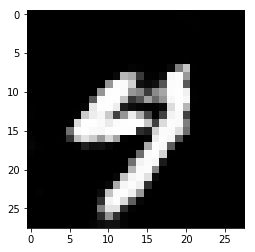

Epoch 2/2... Discriminator Loss: 0.8223... Generator Loss: 2.2524
Epoch 2/2... Discriminator Loss: 0.6765... Generator Loss: 1.5711
Epoch 2/2... Discriminator Loss: 0.6673... Generator Loss: 1.3765
Epoch 2/2... Discriminator Loss: 0.6005... Generator Loss: 1.6810
Epoch 2/2... Discriminator Loss: 0.6397... Generator Loss: 1.7216
Epoch 2/2... Discriminator Loss: 0.5262... Generator Loss: 2.0240
Epoch 2/2... Discriminator Loss: 0.8095... Generator Loss: 1.3073


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7758... Generator Loss: 1.2893
Epoch 1/1... Discriminator Loss: 0.7754... Generator Loss: 1.2012
Epoch 1/1... Discriminator Loss: 0.5984... Generator Loss: 1.7744
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 2.9523
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 1.2598
Epoch 1/1... Discriminator Loss: 1.6813... Generator Loss: 0.4650
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.5883


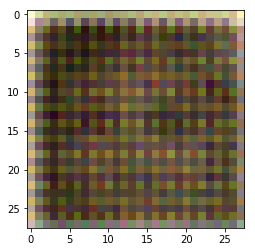

Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.2892
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 1.8129
Epoch 1/1... Discriminator Loss: 0.8218... Generator Loss: 1.9146
Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 1.3849
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.5691
Epoch 1/1... Discriminator Loss: 0.8772... Generator Loss: 1.6669
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 3.0554
Epoch 1/1... Discriminator Loss: 0.8523... Generator Loss: 1.2701


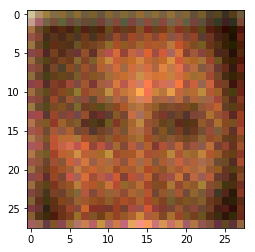

Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 1.1308
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 0.6787... Generator Loss: 1.3340
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 1.5664
Epoch 1/1... Discriminator Loss: 0.8330... Generator Loss: 1.2394
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 1.0693
Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 4.3939
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 0.8312


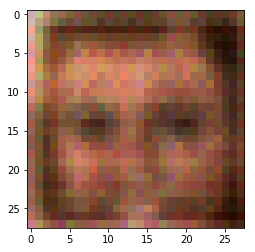

Epoch 1/1... Discriminator Loss: 1.9748... Generator Loss: 0.4505
Epoch 1/1... Discriminator Loss: 0.6716... Generator Loss: 2.7554
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 3.5691
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 2.2688... Generator Loss: 0.3709
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 1.1371
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 3.2328
Epoch 1/1... Discriminator Loss: 1.5699... Generator Loss: 3.3909
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 1.1043
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.6734


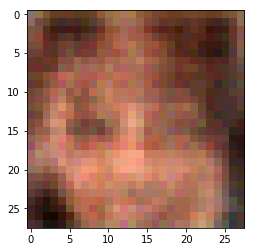

Epoch 1/1... Discriminator Loss: 0.8905... Generator Loss: 1.0029
Epoch 1/1... Discriminator Loss: 1.5355... Generator Loss: 3.1488
Epoch 1/1... Discriminator Loss: 0.8351... Generator Loss: 1.0781
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 1.1420
Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 1.8959... Generator Loss: 0.4046
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 0.8178... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 3.2257
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 0.8828


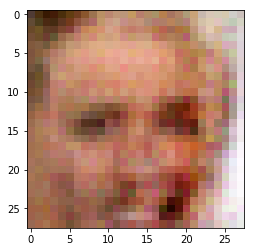

Epoch 1/1... Discriminator Loss: 0.8298... Generator Loss: 1.8472
Epoch 1/1... Discriminator Loss: 0.5247... Generator Loss: 3.5909
Epoch 1/1... Discriminator Loss: 1.8892... Generator Loss: 0.3988
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 1.3298
Epoch 1/1... Discriminator Loss: 1.8428... Generator Loss: 0.4098
Epoch 1/1... Discriminator Loss: 0.8583... Generator Loss: 1.5763
Epoch 1/1... Discriminator Loss: 0.6800... Generator Loss: 1.3363
Epoch 1/1... Discriminator Loss: 0.5986... Generator Loss: 1.6306
Epoch 1/1... Discriminator Loss: 1.6126... Generator Loss: 0.4666
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 1.8939


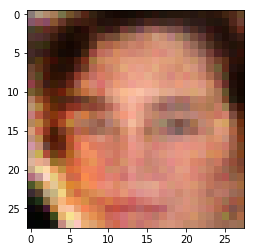

Epoch 1/1... Discriminator Loss: 0.7135... Generator Loss: 3.3619
Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 2.0403
Epoch 1/1... Discriminator Loss: 1.6066... Generator Loss: 0.4602
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.8475... Generator Loss: 0.4076
Epoch 1/1... Discriminator Loss: 0.8416... Generator Loss: 1.9300
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 0.9880
Epoch 1/1... Discriminator Loss: 0.8403... Generator Loss: 2.4613
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 1.0511


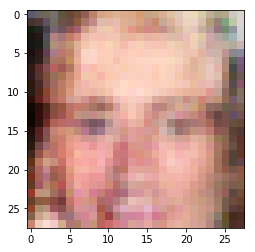

Epoch 1/1... Discriminator Loss: 2.2073... Generator Loss: 0.3672
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 2.4872
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 4.8694
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 2.5756
Epoch 1/1... Discriminator Loss: 0.6007... Generator Loss: 3.1523
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 4.0249
Epoch 1/1... Discriminator Loss: 0.4021... Generator Loss: 4.2515
Epoch 1/1... Discriminator Loss: 0.5683... Generator Loss: 2.5335
Epoch 1/1... Discriminator Loss: 0.6829... Generator Loss: 1.3458


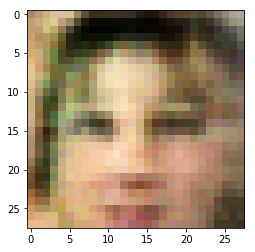

Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 0.9784... Generator Loss: 1.6884
Epoch 1/1... Discriminator Loss: 1.7129... Generator Loss: 0.4308
Epoch 1/1... Discriminator Loss: 0.6090... Generator Loss: 2.8598
Epoch 1/1... Discriminator Loss: 0.4485... Generator Loss: 2.4674
Epoch 1/1... Discriminator Loss: 0.4772... Generator Loss: 4.2091
Epoch 1/1... Discriminator Loss: 0.5143... Generator Loss: 1.8516
Epoch 1/1... Discriminator Loss: 0.4138... Generator Loss: 4.4953
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 2.3711
Epoch 1/1... Discriminator Loss: 0.5249... Generator Loss: 1.7988


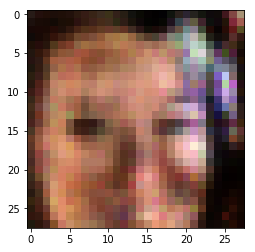

Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 3.4990
Epoch 1/1... Discriminator Loss: 0.4879... Generator Loss: 3.7251
Epoch 1/1... Discriminator Loss: 0.4579... Generator Loss: 2.1484
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 0.7459... Generator Loss: 1.1347
Epoch 1/1... Discriminator Loss: 0.3477... Generator Loss: 5.6338
Epoch 1/1... Discriminator Loss: 0.4009... Generator Loss: 3.8360
Epoch 1/1... Discriminator Loss: 0.5729... Generator Loss: 1.5757
Epoch 1/1... Discriminator Loss: 0.5073... Generator Loss: 1.9829
Epoch 1/1... Discriminator Loss: 0.3790... Generator Loss: 3.4471


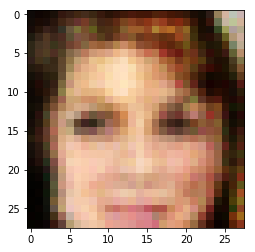

Epoch 1/1... Discriminator Loss: 0.3440... Generator Loss: 5.2254
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 7.7854
Epoch 1/1... Discriminator Loss: 0.6368... Generator Loss: 1.4377
Epoch 1/1... Discriminator Loss: 0.3661... Generator Loss: 3.8961
Epoch 1/1... Discriminator Loss: 0.4751... Generator Loss: 2.7663
Epoch 1/1... Discriminator Loss: 0.4194... Generator Loss: 2.7036
Epoch 1/1... Discriminator Loss: 0.7922... Generator Loss: 7.5800
Epoch 1/1... Discriminator Loss: 0.3760... Generator Loss: 4.5675
Epoch 1/1... Discriminator Loss: 0.3738... Generator Loss: 4.6439
Epoch 1/1... Discriminator Loss: 0.4215... Generator Loss: 3.7429


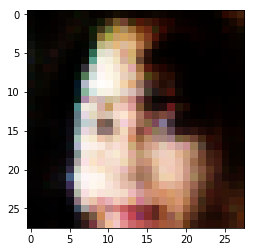

Epoch 1/1... Discriminator Loss: 0.3791... Generator Loss: 3.0801
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 0.4230... Generator Loss: 5.4884
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 1.0961
Epoch 1/1... Discriminator Loss: 0.7592... Generator Loss: 1.0986
Epoch 1/1... Discriminator Loss: 0.3696... Generator Loss: 4.7450
Epoch 1/1... Discriminator Loss: 0.7570... Generator Loss: 1.1242
Epoch 1/1... Discriminator Loss: 0.5546... Generator Loss: 1.5803
Epoch 1/1... Discriminator Loss: 0.4852... Generator Loss: 4.9059
Epoch 1/1... Discriminator Loss: 0.3938... Generator Loss: 3.1049


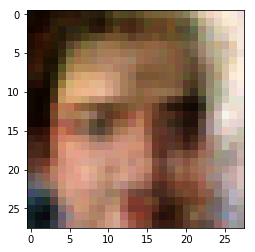

Epoch 1/1... Discriminator Loss: 0.5734... Generator Loss: 1.6786
Epoch 1/1... Discriminator Loss: 0.3476... Generator Loss: 4.3621
Epoch 1/1... Discriminator Loss: 0.5427... Generator Loss: 1.7174
Epoch 1/1... Discriminator Loss: 0.3691... Generator Loss: 4.4805
Epoch 1/1... Discriminator Loss: 0.4704... Generator Loss: 2.1713
Epoch 1/1... Discriminator Loss: 0.3523... Generator Loss: 4.5107
Epoch 1/1... Discriminator Loss: 0.3970... Generator Loss: 3.2059
Epoch 1/1... Discriminator Loss: 0.3980... Generator Loss: 6.8769
Epoch 1/1... Discriminator Loss: 0.4152... Generator Loss: 2.9085
Epoch 1/1... Discriminator Loss: 0.3922... Generator Loss: 2.7843


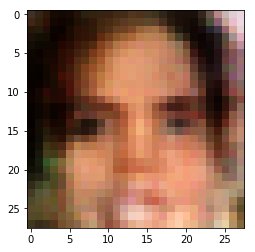

Epoch 1/1... Discriminator Loss: 1.6003... Generator Loss: 0.4922
Epoch 1/1... Discriminator Loss: 0.9218... Generator Loss: 5.2144
Epoch 1/1... Discriminator Loss: 0.3771... Generator Loss: 5.3981
Epoch 1/1... Discriminator Loss: 0.4794... Generator Loss: 2.3061
Epoch 1/1... Discriminator Loss: 0.3579... Generator Loss: 4.6605
Epoch 1/1... Discriminator Loss: 0.4453... Generator Loss: 2.3785
Epoch 1/1... Discriminator Loss: 0.3462... Generator Loss: 5.8415
Epoch 1/1... Discriminator Loss: 0.6418... Generator Loss: 7.1069
Epoch 1/1... Discriminator Loss: 0.4036... Generator Loss: 3.2941
Epoch 1/1... Discriminator Loss: 0.3629... Generator Loss: 3.6974


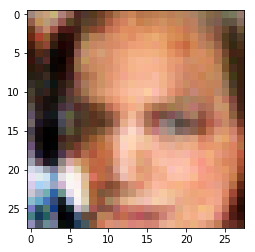

Epoch 1/1... Discriminator Loss: 0.4071... Generator Loss: 2.5648
Epoch 1/1... Discriminator Loss: 0.4046... Generator Loss: 5.0715
Epoch 1/1... Discriminator Loss: 0.3427... Generator Loss: 6.2689
Epoch 1/1... Discriminator Loss: 0.4136... Generator Loss: 2.8314
Epoch 1/1... Discriminator Loss: 0.3694... Generator Loss: 3.4561
Epoch 1/1... Discriminator Loss: 0.6355... Generator Loss: 9.4813
Epoch 1/1... Discriminator Loss: 0.5593... Generator Loss: 1.6576
Epoch 1/1... Discriminator Loss: 0.4252... Generator Loss: 2.3914
Epoch 1/1... Discriminator Loss: 0.3599... Generator Loss: 4.1903
Epoch 1/1... Discriminator Loss: 0.6153... Generator Loss: 1.4254


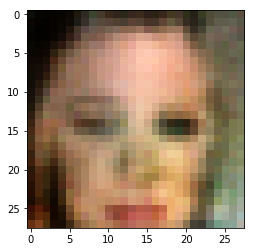

Epoch 1/1... Discriminator Loss: 0.3579... Generator Loss: 3.6861
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 4.7680
Epoch 1/1... Discriminator Loss: 0.5544... Generator Loss: 7.0849
Epoch 1/1... Discriminator Loss: 0.3469... Generator Loss: 5.1305
Epoch 1/1... Discriminator Loss: 0.4188... Generator Loss: 2.7282
Epoch 1/1... Discriminator Loss: 0.3684... Generator Loss: 3.3959
Epoch 1/1... Discriminator Loss: 1.9686... Generator Loss: 8.1197
Epoch 1/1... Discriminator Loss: 0.5586... Generator Loss: 1.6420


In [20]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.